In [1]:
pd.options.mode.chained_assignment = None
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import os
import math
from adjustText import adjust_text

sns.set(rc={'figure.figsize':(20, 30)})

from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
%matplotlib inline
from matplotlib_venn import venn2
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
import pyperclip as pc

# Load files 

In [2]:
eae_genes = pd.read_csv('data\EAE_gene_list.csv')
#ms_genes = pd.read_csv('data\MS_related_genes.csv')
df=pd.read_excel('data\\Unstim_vs_IgE_Differential_Expression.xlsx')

# Preprocess and log transform

In [3]:
def preprocess(df):
    df = df[['Gene Symbol', 'Entrez ID', 'F_unstim_S4', 'M_unstim_S2', 'F_IgE_S3', 'M_IgE_S1']]
    df = df.dropna()
    df = df.replace(0, np.nan)
    df = df.dropna(axis=0, thresh = 4).fillna(0)
    return df
def logs(i):
    i["log_Mi"] = np.log2(i['M_IgE_S1']+1)
    i["log_Fi"] = np.log2(i['F_IgE_S3']+1)
    i["log_Mu"] = np.log2(i['M_unstim_S2']+1)
    i["log_Fu"] = np.log2(i['F_unstim_S4']+1)
    i["unstim_XD"] = i["log_Mu"] - i["log_Fu"]
    i["IgE_XD"] = i["log_Mi"] - i["log_Fi"]
    return i

def sexdominant(i):
    if (i['IgE_XD'] > 0):
        return "M"
    if (i['IgE_XD'] < 0):
        return "F"

In [4]:
df = preprocess(df)
df = logs(df)

df['Sex bias in IgE'] = df.apply(sexdominant, axis=1)

In [5]:
df.head()
df.shape

,Gene Symbol,Entrez ID,F_unstim_S4,M_unstim_S2,F_IgE_S3,M_IgE_S1,log_Mi,log_Fi,log_Mu,log_Fu,unstim_XD,IgE_XD,Sex bias in IgE
0,Ccl1,20290,4.829065,4.680695,23959.367737,43864.638069,15.420804,14.548362,2.506067,2.543265,-0.037197,0.872441,M
1,Serpinb9b,20706,0.804844,2.340347,12956.022455,9704.409675,13.244573,13.661447,1.739998,0.851874,0.888124,-0.416873,F
2,Gstt1,14871,17.706573,7.021042,2446.966235,3081.395634,11.589836,11.257368,3.003790,4.225473,-1.221684,0.332468,M
3,Il9,16198,0.000000,0.000000,3954.312500,3016.280182,11.559033,11.949576,0.000000,0.000000,0.000000,-0.390543,F
4,Slco5a1,240726,15.292041,15.212258,1585.491012,1378.461013,10.429889,10.631624,4.019013,4.026095,-0.007082,-0.201735,F


(14445, 13)

In [6]:
def heatmapper(i):
   # i = i[['Gene Symbol', 'log_Fu', 'log_Mu', 'log_Fi', 'log_Mi', 'Sex bias in IgE']].set_index('Gene Symbol')
    lut = {"M":"blue", "F":"red"}
    row_colors =i.set_index('Gene Symbol')['Sex bias in IgE'].map(lut)
    
    fig = sns.clustermap(data=i.set_index('Gene Symbol')[['log_Fu', 'log_Mu', 'log_Fi', 'log_Mi']], 
               z_score=0,
               metric = 'correlation',
               row_cluster=True, 
               col_cluster=False, 
               cmap='coolwarm',
               figsize=(10, 15),
               cbar_pos=(.1, .81, .05, .1),
               row_colors=row_colors)
    return fig

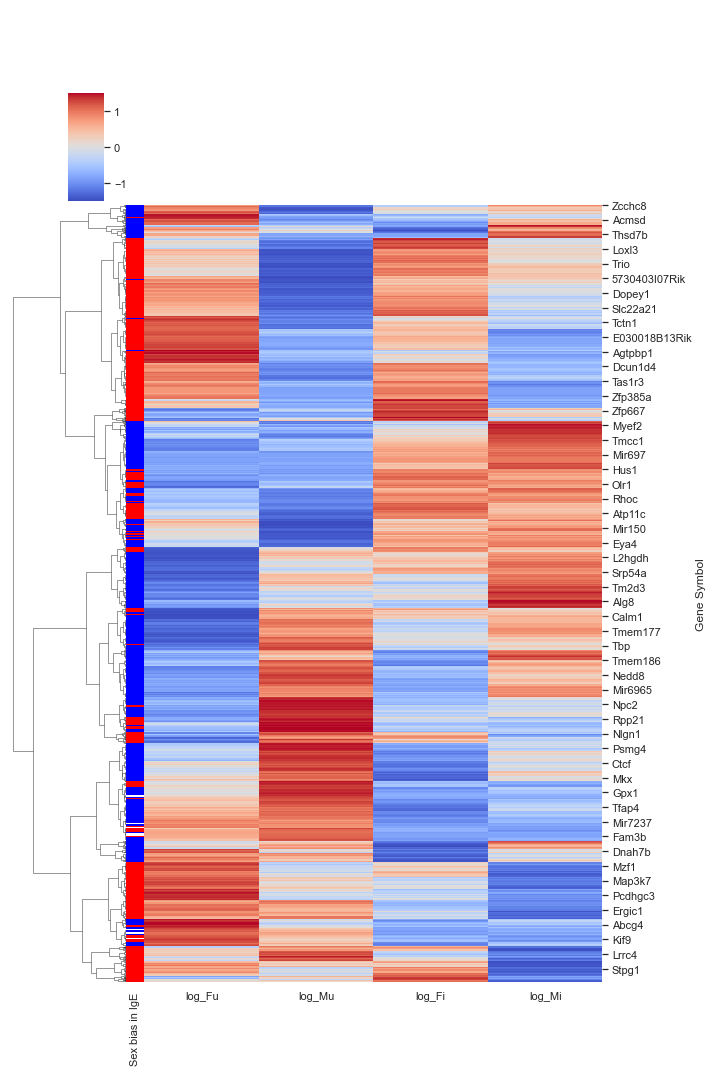

In [44]:
heatmapper(df);

In [7]:
df['Sex bias in IgE'].value_counts()

M    7338
F    6947
Name: Sex bias in IgE, dtype: int64

In [8]:
def ontolist(df1, sex='M'):
    a=''
    if sex=='M':
        for i in df1.loc[df1['Sex bias in IgE']=='M']['Gene Symbol'].tolist():
            a+= i + '\n'
    else:
        for i in df1.loc[df1['Sex bias in IgE']=='F']['Gene Symbol'].tolist():
            a+= i + '\n'
    return pc.copy(a)

# sex difference filter

In [9]:
sex_thresh = 0.58

ige_DEGs = df.loc[(df["IgE_XD"] > sex_thresh) | (df["IgE_XD"] < -1*sex_thresh)]
all_DEGs = df.loc[(df["IgE_XD"] > sex_thresh) | (df["IgE_XD"] < -1*sex_thresh) | (df["unstim_XD"] > sex_thresh) |  (df["unstim_XD"] < -1*sex_thresh)]

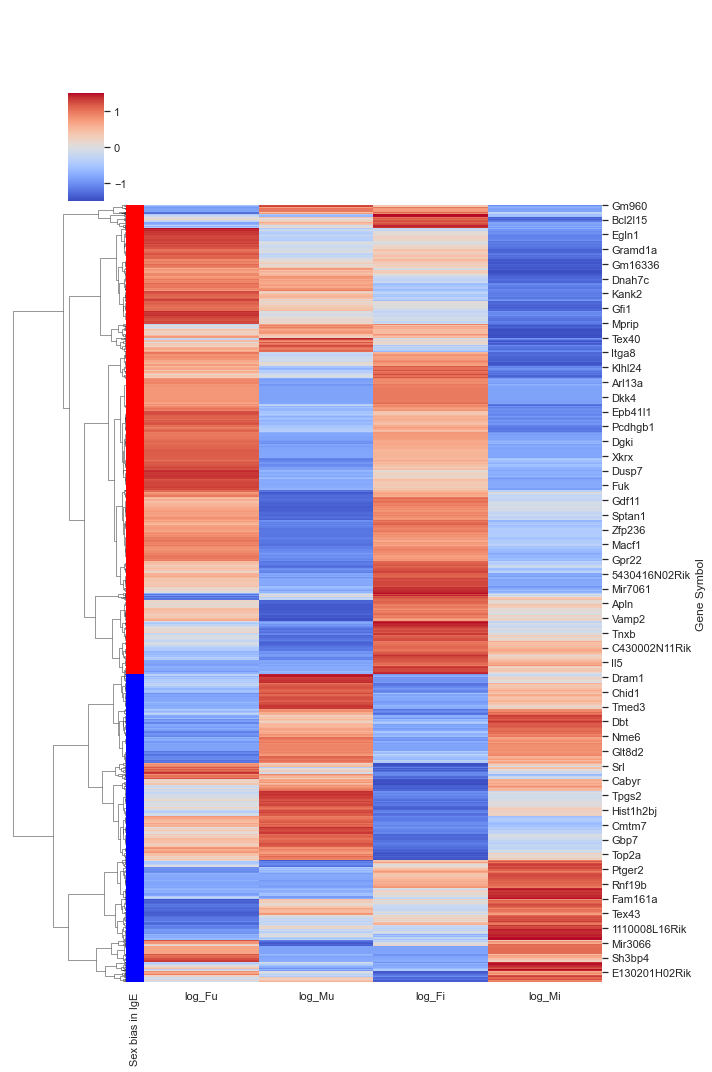

In [46]:
heatmapper(ige_DEGs);

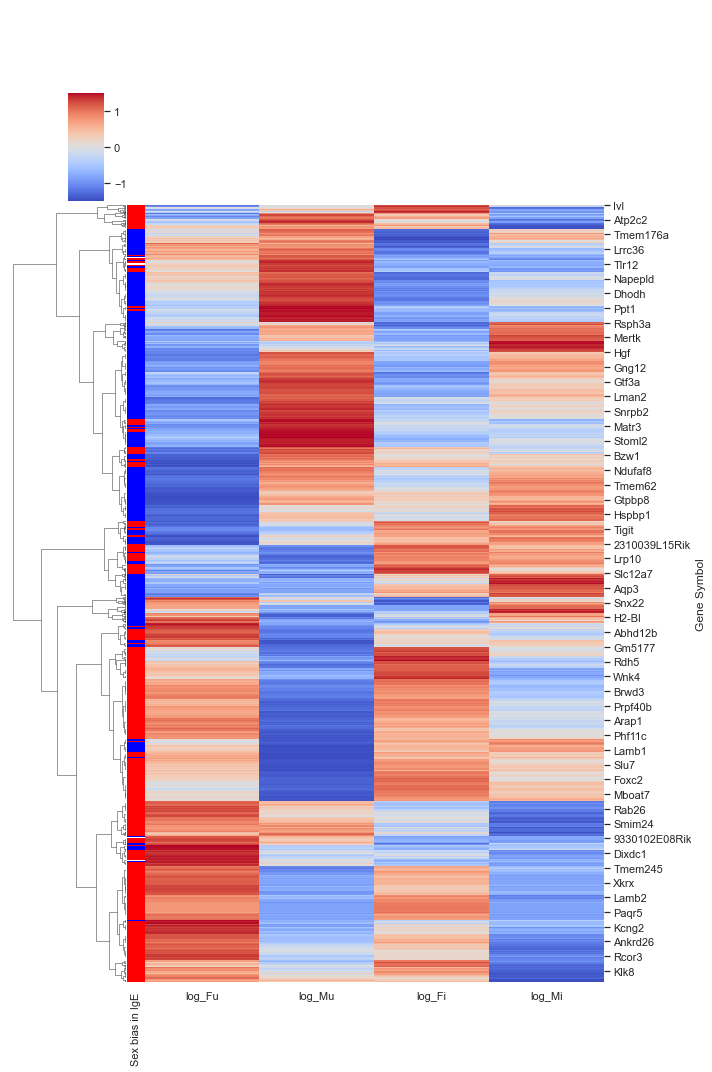

In [47]:
heatmapper(all_DEGs);

In [12]:
for i in [df, ige_DEGs, all_DEGs]:
    i.shape
    i['Sex bias in IgE'].value_counts()

(14445, 13)

M    7338
F    6947
Name: Sex bias in IgE, dtype: int64

(5477, 13)

F    3309
M    2168
Name: Sex bias in IgE, dtype: int64

(9866, 13)

F    5263
M    4530
Name: Sex bias in IgE, dtype: int64

In [66]:
ontolist(ige_DE_eae, "F")

# EAE related genes

In [13]:
eae_genes.shape

(418, 18)

In [14]:
all_eae = df.loc[df['Gene Symbol'].isin(eae_genes['Symbol'])]
all_DE_eae = all_DEGs.loc[all_DEGs['Gene Symbol'].isin(eae_genes['Symbol'])]
ige_DE_eae = ige_DEGs.loc[ige_DEGs['Gene Symbol'].isin(eae_genes['Symbol'])]

In [15]:
all_eae['Sex bias in IgE'].value_counts()
all_DE_eae['Sex bias in IgE'].value_counts()
ige_DE_eae['Sex bias in IgE'].value_counts()

M    156
F    139
Name: Sex bias in IgE, dtype: int64

M    114
F    111
Name: Sex bias in IgE, dtype: int64

M    82
F    70
Name: Sex bias in IgE, dtype: int64

In [53]:
all_eae.shape

(297, 13)

In [41]:
all_eae.to_csv("outputs/220607_all_eae.csv", index=False)
all_DE_eae.to_csv("outputs/220607_all_DE_eae.csv", index=False)
ige_DE_eae.to_csv("outputs/220607_ige_DE_eae.csv", index=False)
ige_DEGs.to_csv("outputs/220607_ige_DEGs.csv", index=False)
all_DEGs.to_csv("outputs/220607_all_DEGs.csv", index=False)

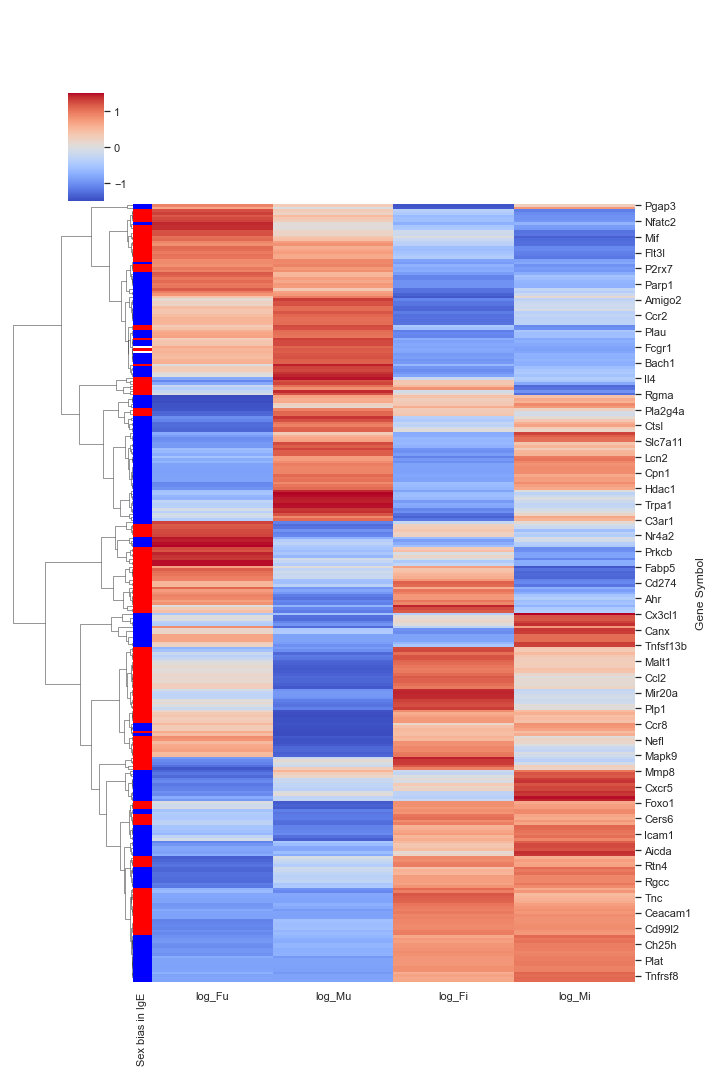

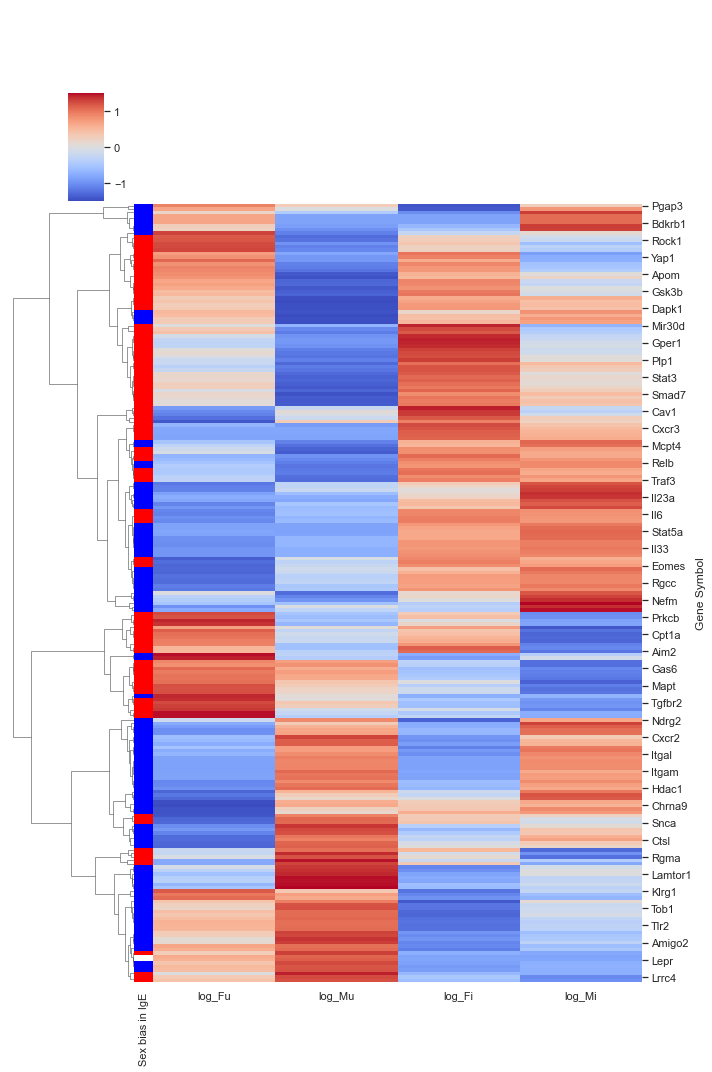

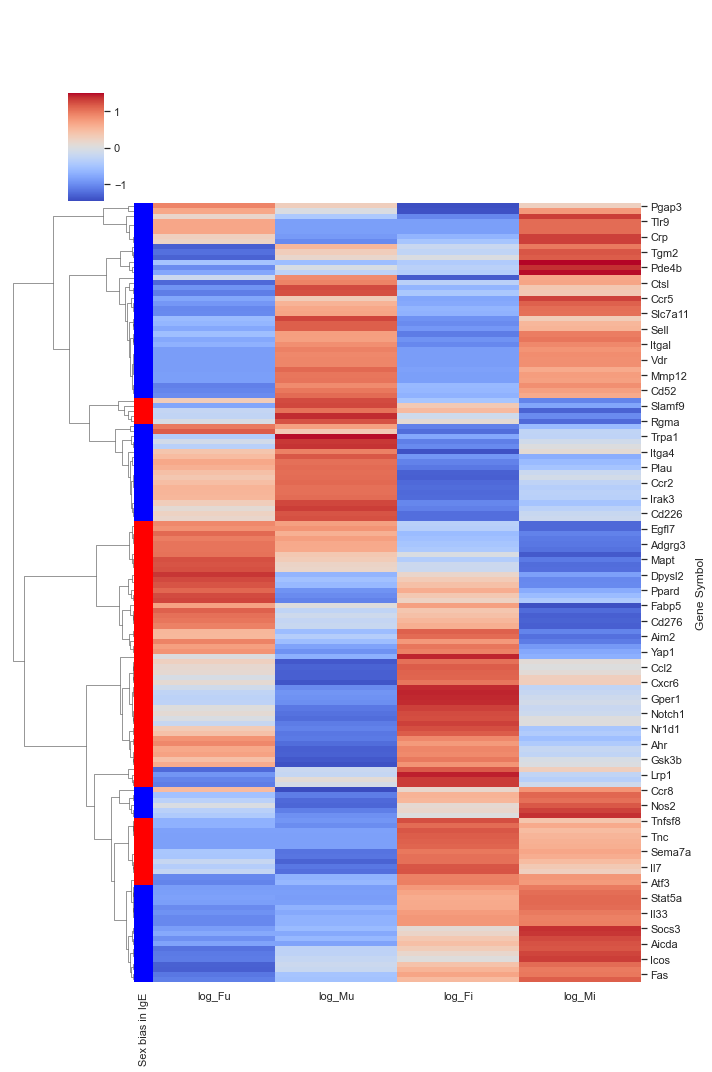

In [49]:
for i in [all_eae, all_DE_eae, ige_DE_eae]:
    heatmapper(i)

In [18]:
GO_lists = []
for i in [df, ige_DEGs, all_DEGs, all_eae, all_DE_eae, ige_DE_eae]:
    GO_lists.append(i.loc[i['Sex bias in IgE']=='M']['Gene Symbol'].tolist())
    GO_lists.append(i.loc[i['Sex bias in IgE']=='F']['Gene Symbol'].tolist())

In [19]:
GO_lists.to

[['Ccl1',
  'Gstt1',
  'Gadd45b',
  'Ccl4',
  'Egr2',
  'Crtam',
  'Prrg4',
  'Car2',
  'Ch25h',
  'Cxcl2',
  'Rgs16',
  'Il33',
  'Mns1',
  'Traf1',
  'Il13',
  'Mgat5',
  'Bcat1',
  'Dusp5',
  'Gp5',
  'Ndrg1',
  'St3gal1',
  'Grm5',
  'Ehd1',
  'B4galt5',
  'Pomt1',
  'Cd82',
  'Rai14',
  'Slc17a8',
  'Mmd',
  'Shtn1',
  'Galnt15',
  'Tspan5',
  'Ccl24',
  'Prss23',
  'C1s2',
  'Pik3r5',
  'Lamc2',
  'Aqp3',
  'Fgd2',
  'Galnt10',
  'Rnf19b',
  'Gng2',
  'Scimp',
  'Cyp4a12a',
  'Hs3st1',
  'Stat5a',
  'Ermp1',
  'Syn2',
  'Pdcd1lg2',
  'Lamtor4',
  'Stx6',
  'Id2',
  'Rap1gap2',
  'Ier5',
  'Cx3cr1',
  'Emc9',
  'Gbp4',
  'Ttc39c',
  'St6galnac4',
  'Ppfibp2',
  'Fam234a',
  'Poln',
  'Havcr2',
  'Ell2',
  'Rabgap1l',
  'Prss35',
  'Nkain1',
  'Ntrk1',
  'Ccdc184',
  'Dusp10',
  'Frmd6',
  'Zap70',
  'Vmn2r79',
  'Junb',
  'Tnip1',
  'Csrnp1',
  'Nek6',
  'Nfam1',
  'Arhgap19',
  'Xcl1',
  'Lig1',
  'Cdk17',
  'Gimap3',
  'Mllt11',
  'Lpcat2',
  'Fas',
  'Marcks',
  'Hfe',
  'Cnn2'

In [20]:
import csv

with open("GO_lists.csv", "w") as f:
    wr = csv.writer(f)
    wr.writerows(GO_lists)